In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd /home/mabitbol/GBT-S140/analysis/

/home/mabitbol/GBT-S140/analysis


In [3]:
import foregrounds as fg
from scipy.optimize import curve_fit
import emcee
import corner

In [4]:
from __future__ import unicode_literals

figsize(16, 10)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
    
rcParams['xtick.labelsize'] = 20
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 0
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1

rcParams['ytick.labelsize'] = 20
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 0
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1

rcParams['legend.fontsize'] = 24
rcParams['legend.borderaxespad'] = 1

rcParams['axes.labelsize'] = 24
rcParams['axes.titlesize'] = 24
rcParams['axes.labelpad'] = 10

In [5]:
bigfs = np.array([  4.08000000e+08,   1.42000000e+09,   4.57500000e+09,
         5.62500000e+09,   6.12500000e+09,   2.84000000e+10,
         4.41000000e+10,   7.04000000e+10,   1.43000000e+11,
         3.53000000e+11,   5.45000000e+11,   8.57000000e+11,
         1.25000000e+12,   2.14200000e+12,   3.00000000e+12])

In [6]:
bigdata = np.array([  1.69932098e+01,   1.88907320e+01,   1.80860056e+01,
         1.75061433e+01,   1.77466662e+01,   3.02925356e+01,
         2.67933107e+01,   2.61128183e+01,   8.87159628e+01,
         1.55447367e+03,   5.19328227e+03,   1.80570130e+04,
         4.39553844e+04,   7.45743649e+04,   4.19317749e+04])

In [7]:
bigerrs = np.array([  2.63219005e+00,   1.98121311e+00,   1.81,
         1.75,   1.76,   1.16505200e+00,
         1.09064996e+00,   1.29007422e+00,   4.88926217e+00,
         7.13450484e+01,   2.27787009e+02,   7.40880194e+02,
         1.14919453e+03,   1.56319215e+03,   8.11448565e+02])

In [8]:
beam = pi*((45./60.)*pi/180.)**2
beam2 = pi*((1./60./60.)*pi/180.)**2

In [9]:
def signal(freqs, EM, Asd, nup, Ad, Bd, Td, Acmb):
    fffit = fg.freefreep(freqs, EM=EM, Te=8000)
    amefit = fg.ame(freqs, Asd=Asd, nup=nup) 
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=Td)
    ccmb = fg.cmb(freqs, A=Acmb)
    return (fffit + dustfit + amefit + ccmb) * beam

In [10]:
pn = np.array([100., 1.e-3, 30.e9, 1.e-4, 2., 20., 30.e-6])
x = curve_fit(signal, bigfs, bigdata, p0=pn, sigma=bigerrs, absolute_sigma=True)
pfit3 = x[0]

In [11]:
figsize(8, 6)

In [12]:
def lnprior(theta):
    EM, Asd, nup, Ad, Bd, Td, Acmb = theta
    if EM < 0 or EM > 1e9:
        return np.inf
    if Asd < 0 or Asd > 1e3:
        return np.inf
    if nup < 1e9 or nup > 1e11:
        return np.inf
    if Ad < 0 or Ad > 1e3:
        return np.inf
    if Bd < 0 or Bd > 100:
        return np.inf
    if Td < 0 or Td > 1000:
        return np.inf
    if np.abs(Acmb) > 1e3:
        return np.inf
    return 0.

In [13]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [14]:
def lnlike(theta, x, y, yerr):
    EM, Asd, nup, Ad, Bd, Td, Acmb = theta
    fffit = fg.freefreep(x, EM=EM, Te=8000.)
    dustfit = fg.thermal_dust(x, Ad=Ad, Bd=Bd, Td=Td)
    amefit = fg.ame(x, Asd=Asd, nup=nup) 
    ccmb = fg.cmb(x, A=Acmb)
    model = (fffit + dustfit + amefit + ccmb) * beam
    return -0.5 * (np.sum((y - model)**2. * yerr**-2.))

In [18]:
ndim, nwalkers = 7, 128
pos = [pfit3 * (1. + 1.e-3*np.random.randn(ndim)) for i in range(nwalkers)]

In [19]:
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(bigfs, bigdata, bigerrs))

In [20]:
sampler2.run_mcmc(pos, 2**16);

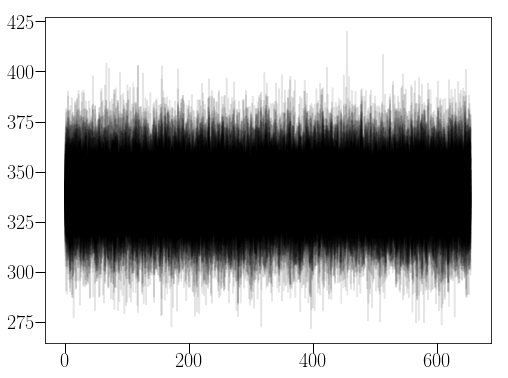

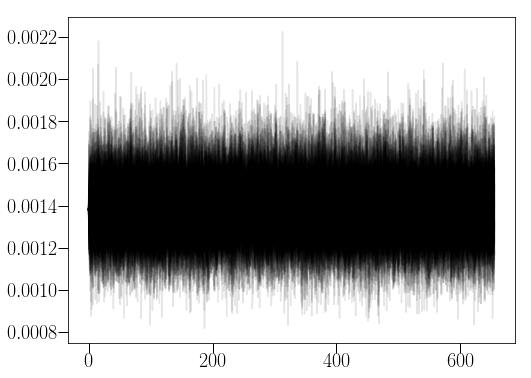

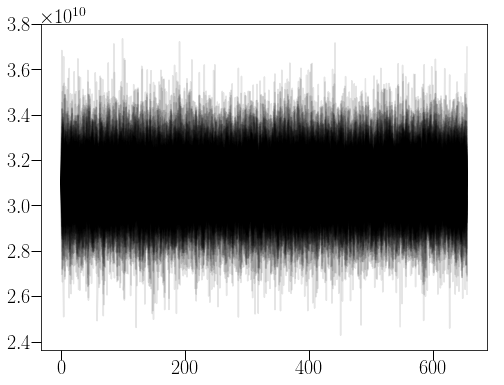

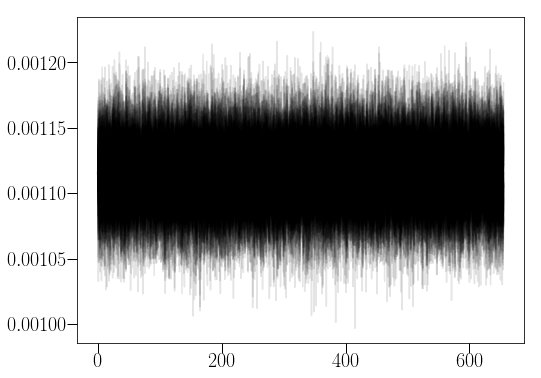

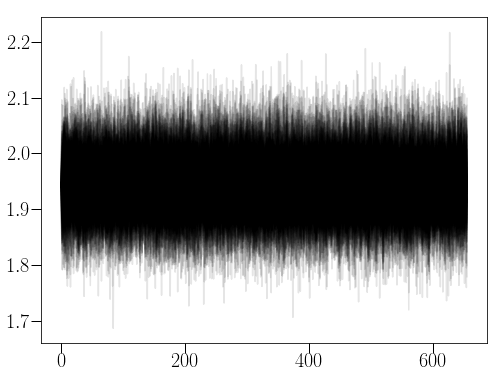

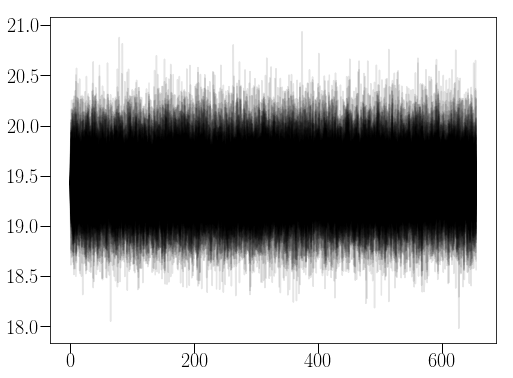

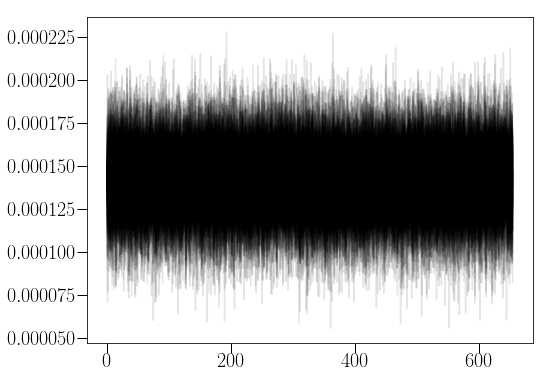

In [21]:
figsize(8, 6 )
for k in range(ndim):
    figure()
    plot(sampler2.chain[:,::100,k].T, color='k', alpha=0.1);

In [22]:
samples2 = sampler2.chain[:, 10000:, :].reshape((-1, ndim))

In [23]:
datas2 = samples2.copy()

In [24]:
datas2[:, 1] *= 1e6
datas2[:, 2] *= 1e-9
datas2[:, 3] *= 1e6
datas2[:, 6] *= 1e6

In [25]:
figsize(16, 10)

In [26]:
#datas2 = np.load('mcmc_spinningdust_samples.npy')

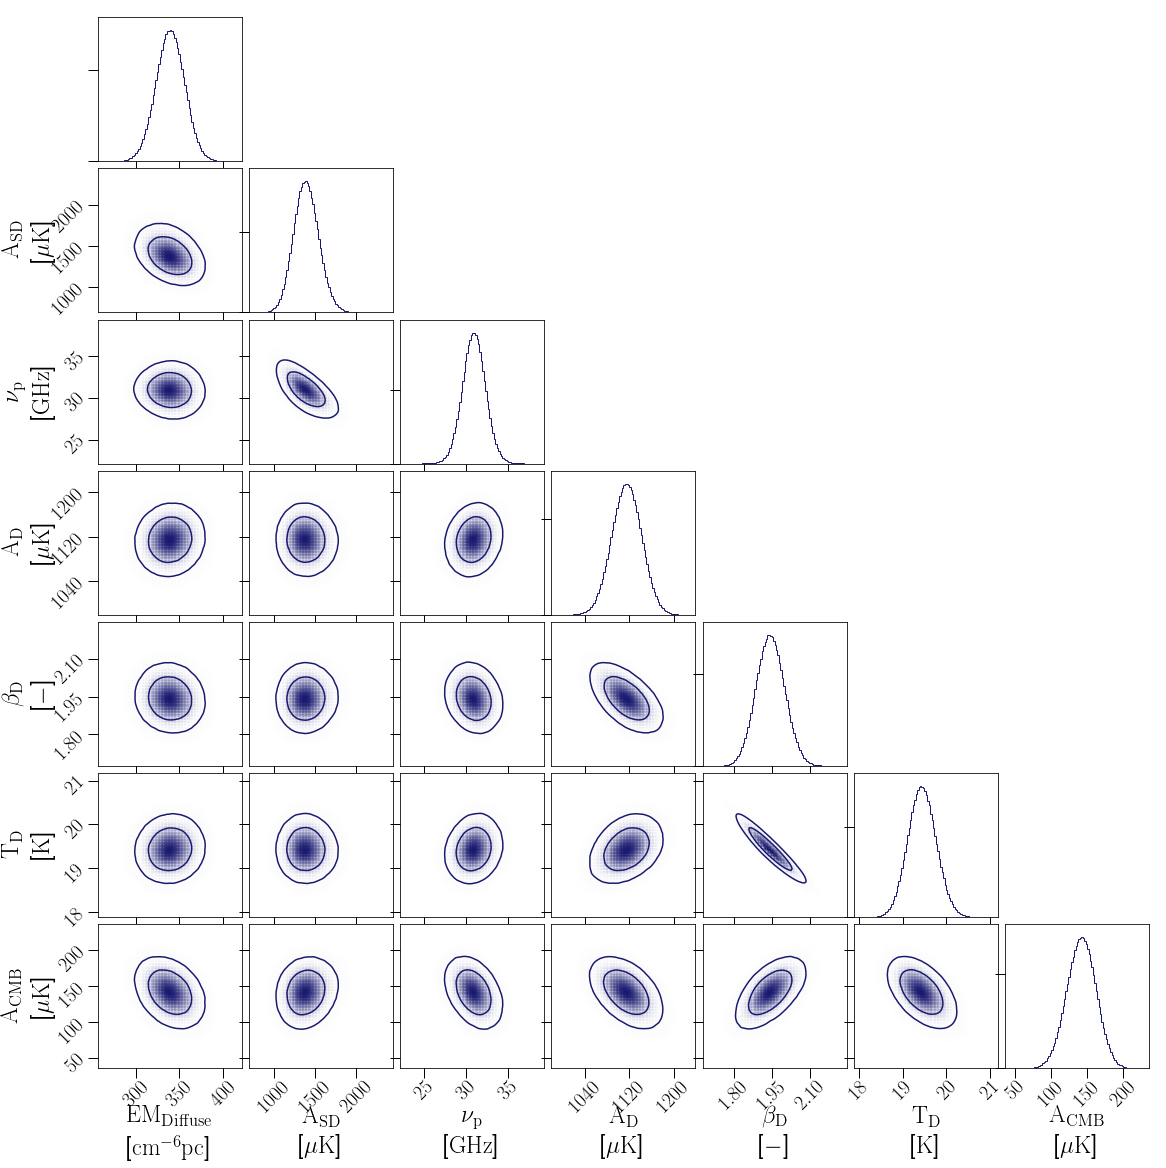

In [27]:
fig = corner.corner(datas2, plot_datapoints=False, bins=100, levels=[0.68,0.95], smooth=1.,\
                    labels=["$\mathrm{EM_{Diffuse}}$\n [$\mathrm{cm^{-6} pc}$]", 
                            "$\mathrm{A_{SD}}$\n [$\mathrm{\mu K}$]", 
                            "$\mathrm{\\nu_{p}}$\n [$\mathrm{GHz}$]",
                            "$\mathrm{A_{D}}$\n [$\mathrm{\mu K}$]", 
                            "$\mathrm{\\beta_{D}}$\n [$-$]", 
                            "$\mathrm{T_{D}}$\n [$\mathrm{K}$]", 
                            "$\mathrm{A_{CMB}}$\n [$\mathrm{\mu K}$]"], \
                    color='midnightblue', max_n_ticks=4)
#savefig('/home/mabitbol/GBT-S140/notebooks/spinningdust_posterior.png', format='png', bbox_inches='tight', dpi=300)

In [25]:
#np.save('mcmc_spinningdust_samples', datas2)

In [26]:
print "EM, Asd, nup, Ad, Bd, Td, Acmb"
map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(datas2, [16, 50, 84], axis=0)))

EM, Asd, nup, Ad, Bd, Td, Acmb


[(339.00198866819659, 16.34227600556062, 16.307457327820032),
 (1383.7915353107337, 156.22407968205971, 147.63374776644673),
 (30.896860063159988, 1.3605942508634818, 1.3576929085611944),
 (1114.5799103162899, 26.755511031099559, 26.846381727402786),
 (1.9436272364778697, 0.056712655302093795, 0.055856226062443559),
 (19.428594034670922, 0.32325820306886044, 0.31438630433699188),
 (142.37831063748197, 19.964382855397361, 20.366258235186834)]

In [28]:
print "EM, Asd, nup, Ad, Bd, Td, Acmb"
map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(datas2, [16, 50, 84], axis=0)))

EM, Asd, nup, Ad, Bd, Td, Acmb


[(339.16099214019528, 16.347253083561668, 16.334018699154683),
 (1382.7402601991012, 155.21837717760286, 147.47684653820215),
 (30.90772957096782, 1.3612141485870559, 1.3571764073578834),
 (1114.8233104703049, 26.658105321768289, 26.870008189698183),
 (1.9424712412779721, 0.057014750728992425, 0.055648042009258436),
 (19.433975769056296, 0.32391743686337549, 0.31601946318061636),
 (142.11733081376263, 20.004688386323352, 20.480939634602393)]

In [27]:
vds = zip(*np.percentile(datas2, [16, 50, 84], axis=0))

In [28]:
names = ["EM", "Asd", "nup", "Ad", "Bd", "Td", "Acmb"]

In [29]:
for k in range(len(vds)):
    print names[k], '{0:1.3g}'.format(vds[k][1]), '{0:1.2g}'.format(vds[k][2] - vds[k][1]), \
          '{0:1.2g}'.format(vds[k][1] - vds[k][0], 1)

EM 339 16 16
Asd 1.38e+03 1.6e+02 1.5e+02
nup 30.9 1.4 1.4
Ad 1.11e+03 27 27
Bd 1.94 0.057 0.056
Td 19.4 0.32 0.31
Acmb 142 20 20
